In [7]:
import getpass
import os
if( os.system('klist | grep Default | grep mbonanom@CERN.CH') ):
   os.system('echo %s | kinit mbonanom' % getpass.getpass() )

Default principal: mbonanom@CERN.CH


In [8]:
v10_prefix = 'root://eoscms.cern.ch//eos/cms/store/group/dpg_hgcal/tb_hgcal/2018/cern_h2_october/offline_analysis/ntuples/v10/'

In [9]:
v11_prefix = 'root://eoscms.cern.ch//eos/cms/store/group/dpg_hgcal/tb_hgcal/2018/cern_h2_october/offline_analysis/ntuples/v11/'

In [10]:
v9_prefix = 'root://eoscms.cern.ch//eos/cms/store/group/dpg_hgcal/tb_hgcal/2018/cern_h2_october/offline_analysis/ntuples/v9/'

In [11]:
v8_prefix = 'root://eoscms.cern.ch//eos/cms/store/group/dpg_hgcal/tb_hgcal/2018/cern_h2_october/offline_analysis/ntuples/v8/'

In [12]:
import pandas as pd
import numpy as np
from scipy.stats import norm
import matplotlib.mlab as mlab
from root_pandas import read_root
import itertools

import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
gamma = 0.3
#from mpl_toolkits.mplot3d import Axes3D
from matplotlib.colors import LogNorm
mpl.rcParams['image.cmap'] = 'viridis'

%matplotlib inline

In [13]:
from scipy.optimize import curve_fit
from scipy.stats import binned_statistic#, binned_statistic_2d
from scipy.special import erf
from scipy.stats import iqr

In [14]:
from collections import defaultdict
import os.path

In [15]:
font = {'family' : 'DejaVu Sans',
        'weight' : 'normal',
        'size'   : 16}

mpl.rc('font', **font)

In [16]:
def line(x, m, q):
    return m*x + q

In [17]:
def E_res(x, p0, p1, p2):
    return np.sqrt((p0/np.sqrt(x))**2 + (p1/x)**2 + (p2)**2)

In [18]:
def err_prop(sigma, E, err_sigma, err_E):
    n = sigma/E
    dval1 = err_sigma/sigma
    dval2 = err_E/E
    return n*np.sqrt((dval1)**2 + (dval2)**2)

In [19]:
def gaussian(x, amplitude, mean, standard_deviation):
    return amplitude * np.exp( - 0.5*((x - mean) / standard_deviation) ** 2)

In [20]:
def gausExp(x, xb, sig, k, N):
    if k < 0:
        k = -k

    total = 0.*x
    total += ((x-xb)/sig  > -k) * N * np.exp(- (x-xb)**2/(2.*sig**2))
    total += ((x-xb)/sig <= -k) * N * np.exp(k**2/2. + k*((x-xb)/sig))

    return total


In [21]:
from scipy.special import erf

def crystal_ball(x, a, n, xb, sig):
    x = x+0j
    if a < 0:
        a = -a
    if n < 0:
        n = -n
    aa = abs(a)
    A = (n/aa)**n * np.exp(- aa**2 / 2)
    B = n/aa - aa
    C = n/aa*1/(n-1)*np.exp(- aa**2 / 2)
    D = np.sqrt(np.pi/2)*(1+erf(aa/np.sqrt(2)))
    N = 1./(sig*(C+D))
    total = 0.*x
    total += ((x-xb)/sig  > -a) * N * np.exp(- (x-xb)**2/(2.*sig**2))
    total += ((x-xb)/sig <= -a) * N * A * (B - (x-xb)/sig)**(-n)
    try:
        return total.real
    except:
        return total
    return total


In [22]:
def CBFit(histogram, energy):
    binning = 100
    if (energy > 100):
        binning = 200
    upLim = 8
    dLim = 12
#     n, bins, patch = plt.hist(histogram, density=1, color = 'cyan', histtype='step', linewidth=2, bins=binning)
    n, bins = np.histogram(histogram, density=1, bins=binning)
    bins = 0.5*(bins[1:]+bins[:-1])
    
    popt, pcov = curve_fit(crystal_ball, bins, n)
    h_std = np.sqrt(Noise*Noise + Sampl*Sampl/energy + Linear*Linear/(energy**2))

    sel = (bins > histogram.median()*0.6) & (bins < histogram.median()*1.2)
    xmed = bins[np.argmax(n)]
    popt, pcov = curve_fit(crystal_ball, bins[sel], n[sel], p0=[ 1.1, 3, xmed, h_std])    
    
    E = popt[2]
    sig = popt[3]
    errors = np.sqrt(np.diag(pcov))
    err_E = errors[2]
    err_sig = errors[3]
    resolution = sig/E
    err_res = err_prop(sig, E, err_sig, err_E)
   
    xmax = bins[np.argmax(n)]
    xdraw = np.linspace(0, histogram.max(), 1000)
    plt.plot(xdraw, crystal_ball(xdraw, *popt), linewidth=2, color='cyan', label = r'$\sigma$/E (CB) = %.3f' %resolution)
#     plt.xlim(xmax - dLim*sig, xmax + upLim*sig)
    plt.legend()#title="CB fit")

    return resolution, E, err_res

In [23]:
Sampl = 2.198e-01
Noise = 8.210e-03
Linear = 3e-6

def GausExpFit(histogram, energy):
    binning = 100
    if (energy > 100):
        binning = 200
    upLim = 8
    dLim = 12

#     n, bins, patch = plt.hist(histogram, density=1, color = 'red', alpha=0.6, bins=binning)
    n, bins = np.histogram(histogram, density = 1, bins=binning)
    bins = 0.5*(bins[1:]+bins[:-1])
    xmax = bins[np.argmax(n)]
    ymax = n.max()
    sel = (bins > histogram.median()*0.5) & (bins < histogram.median()*1.5)

    popt, pcov = curve_fit(gausExp, bins[sel], n[sel], p0 = [xmax, 0.054, 0.5, ymax]) 
    popt, pcov = curve_fit(gausExp, bins[sel], n[sel], p0 = popt)
    E = popt[0]
    sig = popt[1]
    errors = np.sqrt(np.diag(pcov))
    err_E = errors[0]
    err_sig = errors[1]
    resolution = sig/E
    err_res = err_prop(sig, E, err_sig, err_E)
    
    xmax = bins[np.argmax(n)]
    xdraw = np.linspace(0, histogram.max(), 1000)
    plt.plot(xdraw, gausExp(xdraw, *popt), linewidth=2, color = 'red', label = r'$\sigma$/E (GE) = %.3f' %resolution)
#     plt.xlim(xmax - dLim*sig, xmax + upLim*sig)
    plt.legend()#title="gausExp fit")

    return resolution, E, err_res

In [49]:
Sampl = 2.198e-01
Noise = 8.210e-03
Linear = 3e-6

def repeatedGausFit(histogram, energy, rangeInSigmaLeft = 1, rangeInSigmaRight = 2.5):
    binning = 300
    n, bins, patch = plt.hist(histogram, density = 1, alpha =0.6, bins=binning)
    n, bins = np.histogram(histogram, density = 1, bins=binning)
    bins = 0.5*(bins[1:]+bins[:-1])
    
    h_med = bins[np.argmax(n)]
    h_std = np.sqrt(Noise*Noise + Sampl*Sampl/energy + Linear*Linear/(energy**2))
    s_fit = (bins > h_med - rangeInSigmaLeft*h_std)& (bins < (h_med + rangeInSigmaRight*h_std))
    ymaximum = n.max()
    plt.xlim(histogram.median()*0.6, histogram.median()*1.5)
    popt, pcov = curve_fit(gaussian, bins[s_fit], n[s_fit], p0=[ymaximum, h_med, h_std])
#     popt, pcov = curve_fit(lambda x, mean, st_dev: gaussian(x, ymaximum, mean, st_dev), bins[s_fit], n[s_fit], 
#                        p0=[h_med, h_std])
#     print popt
    mu_tmp = popt[1]
    std_tmp = popt[2]
    ymaximum_tmp = popt[0]
    s_fit = (bins > mu_tmp- rangeInSigmaLeft*std_tmp) & (bins < mu_tmp + rangeInSigmaRight*std_tmp)
    popt, pcov = curve_fit(gaussian, bins[s_fit], n[s_fit], p0=[ymaximum_tmp, mu_tmp, std_tmp])
#     popt, pcov = curve_fit(lambda x, mean, st_dev: gaussian(x, ymaximum, mean, st_dev), bins[s_fit], n[s_fit], 
#                        p0=[mu_tmp, std_tmp])
#     print popt
    
    e_reco = popt[1]
    sigma = popt[2]
    err = np.sqrt(np.diag(pcov))
    E_err = err[1]
    sigma_err = err[2]
    resolution = sigma/e_reco
    res = ((n[s_fit] - gaussian(bins[s_fit], *popt))/gaussian(bins[s_fit], *popt))**2
    chi2 = np.sum(res)/(len(bins[s_fit])-len(popt))
    xdraw = np.linspace(popt[1]-rangeInSigmaLeft*popt[2],popt[1]+rangeInSigmaRight*popt[2], 1000)
    plt.plot(xdraw, gaussian(xdraw, popt[0], popt[1],  popt[2]), linewidth=2, label=r'$\sigma/E (Gaus)$ = %.3f' %resolution)

    return e_reco, sigma, E_err, sigma_err, popt[0], chi2

In [25]:
def is_electron(df):
    if df.pdgID[0] == 11: return True
    else: return False

In [26]:
w = [10.199, 9.851, 9.851, 9.851, 9.851, 9.851, 9.851, 9.851, 9.851, 9.851, 9.851, 9.851,
    9.851, 9.851, 9.851, 9.851, 9.851, 9.851, 9.851, 9.851, 11.360, 11.360, 11.360, 11.360,
    10.995, 10.995, 11.153, 36.139, 57.496, 57.654, 57.654, 57.654, 56.884, 38.620, 39.390,
    57.654, 58.083, 57.757, 56.574, 37.755]
w_tot = sum(w)
X0 = [0.943, 1.923, 2.858, 3.838, 4.773, 5.753, 6.688, 7.668, 8.603, 9.583,
 10.518, 11.498, 12.433, 13.413, 14.348, 15.328, 16.263, 17.243, 18.178,
 19.157, 20.092, 21.240, 22.174, 23.322, 24.256, 25.505, 26.440,
 27.725, 30.566, 33.501, 36.437, 39.373, 42.308, 45.159, 46.275, 49.211,
 52.146, 55.276, 58.322, 61.175]

weights = dict()
lay_X0 = dict()
su = 0
for i in range(len(w)):
    weights[i+1] = (w[i]/w_tot) #dEdx are averaged in MeV/MIP --> convert to GeV
    lay_X0[i+1] = (X0[i])


In [27]:
simul_reso = [0.05252533050053361, 0.04246531378576422, 0.03316893269421308, 0.026026766200077246, 0.023539708490593735, 
              0.020451829612688918, 0.01862616723089308, 0.017134081339427978, 0.016346269539945477]

E_MC = [0.17205952777473252, 0.25891686515687895, 0.4322641161581555, 0.6915440898971871, 0.8641409222828782, 1.2897407103365943, 
        1.7044081463354082, 2.103598722522489, 2.4799942424055996]


In [28]:
#1 MIP = 84.9 keV for all layers (see: https://gitlab.cern.ch/cms-hgcal-tb/TestBeam/wikis/samples/October2018-CERN)
MIPtoGeV = 84.9*1e-6

<h1> STABILITY FOR SAME ENERGY RUNS </h1>

In [ ]:
_20GeV = range(436, 456)
_30GeV = range(594, 608)
_50GeV = range(456, 466) + range(608, 620)
_80GeV = range(466, 476) + range(655, 664)
_100GeV = range(477, 492)
_120GeV = range(361, 372) + range(382, 384) + range(620, 645)
_150GeV = range(303, 319) + range(337, 361) + range(493, 510)
_200GeV = range(372, 382) + range(664, 677)
_250GeV = range(384, 405) + range(645, 655)
_300GeV = range(405, 435)

In [ ]:
branches = [u'event', 'beamEnergy', u'rechit_module',u'rechit_chip', # 'pdgID', u'rechit_chip', u'rechit_channel',
       u'rechit_layer', u'rechit_energy']

rh_branches = [branch for branch in branches if 'rechit' in branch]
energies  = [20,  30,  50,  80,  100, 120, 150, 200, 250, 300]
medians = defaultdict(list)
medians_w = defaultdict(list)
run_id = defaultdict(list)

In [ ]:
%%time

for i in range(len(energies)):
    energy = energies[i]
    runs = '_%iGeV' %energy
    runs = eval(runs)
    for j in range(len(runs)):
        run = runs[j]
        try:
            fname = v11_prefix + 'ntuple_%i.root' %run
            df = read_root(fname,key='rechitntupler/hits',columns = branches, flatten = rh_branches)
            df['rechit_energy_w'] = df['rechit_energy']*MIPtoGeV
            run_id[energy].append(run)
            
            sel_en = (df.rechit_energy>0.5) #& (df.rechit_chip != 3) #& (df.rechit_layer <= 28)
            sel_en &= ~((df.rechit_module == 78) & (df.rechit_chip == 0))
            #sel_en &= ~((df.rechit_chip == 3) & (df.rechit_channel == 22))

            df_sel = df[sel_en]
            sum_en = df_sel.groupby('event')['rechit_energy'].sum()
            medians[energy].append(sum_en.median())

            sum_en = df_sel.groupby('event')['rechit_energy_w'].sum()
            medians_w[energy].append(sum_en.median()/energy)  
        except IOError:
            continue

In [ ]:
plt.figure(figsize=(10,8))
for i in range(len(energies)):
    energy = energies[i]
#     if energy > 120:
    plt.plot(run_id[energy], medians_w[energy], 'o', label = '%i GeV' %energy)
plt.legend()
plt.ylim(0.007, 0.009)
plt.grid()
plt.ylabel(r'Median E/$E_{Beam}$')
plt.xlabel('run number')
plt.axvline(x=589, color='black', linestyle = '-.')

In [ ]:
energy = 200
run_bad = 376
branches = [u'event', 'beamEnergy', u'rechit_module', u'rechit_chip', u'rechit_channel',
       u'rechit_layer', u'rechit_energy']

rh_branches = [branch for branch in branches if 'rechit' in branch]
fname = v9_prefix + 'ntuple_%i.root' %run_bad
df = read_root(fname,key='rechitntupler/hits',columns = branches, flatten = rh_branches)
df['rechit_energy_w'] = df['rechit_energy']*(df['rechit_layer'].map(weights))

sel_en = (df.rechit_energy > 0.5) #& (df.rechit_layer > 28)
sel_en &= ~((df.rechit_chip == 3) & (df.rechit_channel == 22))

df_sel = df[sel_en]

sum_en_bad = df_sel.groupby('event')['rechit_energy_w'].sum()

sel_en = (df.rechit_energy > 0.5) & (df.rechit_layer > 28)
df_sel = df[sel_en]

sum_en_FH_bad = df_sel.groupby('event')['rechit_energy_w'].sum()

sel_en = (df.rechit_energy > 0.5) & (df.rechit_layer <= 28)
df_sel = df[sel_en]
sum_en_EE_bad = df_sel.groupby('event')['rechit_energy_w'].sum()


In [ ]:
plt.figure(figsize=(10,8))
plt.title('Run %i. %i GeV' %(run_bad, energy))
sel = sum_en_FH_bad<100
r = plt.hist2d(sum_en_EE_bad[sel], sum_en_FH_bad[sel], 300, cmap='viridis', norm=LogNorm())#mcolors.PowerNorm(gamma))
plt.xlabel('EE energy [GeV]')
plt.ylabel('FH energy [GeV]')

In [ ]:
run_good = 672
fname = v9_prefix + 'ntuple_%i.root' %run_good
df = read_root(fname,key='rechitntupler/hits',columns = branches, flatten = rh_branches)
df['rechit_energy_w'] = df['rechit_energy']*(df['rechit_layer'].map(weights))

sel_en = (df.rechit_energy > 0.5) #& (df.rechit_layer > 28)
sel_en &= ~((df.rechit_chip == 3) & (df.rechit_channel == 22))

df_sel = df[sel_en]

sum_en_good = df_sel.groupby('event')['rechit_energy_w'].sum()

sel_en = (df.rechit_energy > 0.5) & (df.rechit_layer > 28)
df_sel = df[sel_en]

sum_en_FH_good = df_sel.groupby('event')['rechit_energy_w'].sum()

sel_en = (df.rechit_energy > 0.5) & (df.rechit_layer <= 28)
df_sel = df[sel_en]
sum_en_EE_good = df_sel.groupby('event')['rechit_energy_w'].sum()


In [ ]:
plt.figure(figsize=(10,8))
plt.title('Run %i. %i GeV' %(run_good, energy))
sel = sum_en_FH_good<100
r = plt.hist2d(sum_en_EE_good[sel], sum_en_FH_good[sel], 300, cmap='viridis', norm=LogNorm())#mcolors.PowerNorm(gamma))
plt.xlabel('EE energy [GeV]')
plt.ylabel('FH energy [GeV]')

In [ ]:
plt.figure(figsize=(20,10))
plt.subplot(121)
plt.title('All Layers')
r= plt.hist(sum_en_good, normed=1, bins=500, label='Run %i' %run_good)
r= plt.hist(sum_en_bad, normed=1, bins=500, alpha=0.7, label='Run %i' %run_bad)
plt.xlabel('E dE/dX [GeV]')
plt.legend()

plt.subplot(122)
plt.title('EE layers')
r= plt.hist(sum_en_EE_good, normed=1, bins=500, label='Run %i' %run_good)
r= plt.hist(sum_en_EE_bad, normed=1, bins=500, alpha=0.7, label='Run %i' %run_bad)
plt.xlabel('E dE/dX [GeV]')
plt.legend()

plt.figure(figsize=(20,10))
plt.subplot(121)
plt.title('RUN %i' %run_bad)
# r= plt.hist(sum_en_bad, normed=1, bins=500, label='Run %i, all layers' %run_bad)
# r= plt.hist(sum_en_EE_bad, normed=1, bins=500, alpha=0.7, label='Run %i, EE' %run_bad)
r=plt.hist2d(sum_en_EE_bad, sum_en_bad, 300, cmap='viridis', norm=LogNorm())#mcolors.PowerNorm(gamma))
plt.xlabel('E in EE, dE/dX [GeV]')
plt.ylabel('E tot, dE/dX [GeV]')
# plt.legend()

plt.subplot(122)
plt.title('RUN %i' %run_good)
# r= plt.hist(sum_en_good, normed=1, bins=500, label='Run %i, all layers' %run_good)
# r= plt.hist(sum_en_EE_good, normed=1, bins=500, alpha=0.7, label='Run %i, EE' %run_good)
r=plt.hist2d(sum_en_EE_good, sum_en_good, 300, cmap='viridis', norm=LogNorm())#mcolors.PowerNorm(gamma))
plt.xlabel('E in EE, dE/dX [GeV]')
plt.ylabel('E tot, dE/dX [GeV]')
# plt.legend()

<h1> ENERGY RESOLUTION </h1>

In [29]:
# energies  = [20,  30,  50,  80,  100, 120, 150, 200, 250, 300]
energies = [20, 30, 49.99, 79.93, 99.83, 119.65, 149.14, 197.32, 243.61, 287.18]
runs      = [455, 607, 458, 469, 490, 641, 494, 664, 653, 435]
# runs      = [455, 607, 457, 469, 477, 382, 494, 664, 653, 405]
branches = [u'event', 'beamEnergy', 'pdgID', u'rechit_chip', u'rechit_channel', 'rechit_module'
       u'rechit_layer', u'rechit_energy', u'rechit_energy_noHG', u'rechit_x', u'rechit_y']
dwc_branches = [u'event', u'ntracks']
rh_branches = [branch for branch in branches if 'rechit' in branch]


In [34]:
def add_dwc(run, location, version):
    branches = [u'event', u'rechit_chip', u'rechit_channel', 'rechit_module',
       u'rechit_energy', u'rechit_x', u'rechit_y']
    dwc_branches = [u'event', u'ntracks', u'b_x', u'b_y']
    rh_branches = [branch for branch in branches if 'rechit' in branch]

    fname = location + 'ntuple_%i.root' %run
    df = read_root(fname,key='rechitntupler/hits',columns = branches, flatten = rh_branches)
    if (version == 9):
        df['rechit_energy_w'] = df['rechit_energy']*MIPtoGeV*1.14
    if (version == 8):
        df['rechit_energy_w'] = df['rechit_energy']*MIPtoGeV*1.105
    if ((version == 10) | (version == 11)):
        df['rechit_energy_w'] = df['rechit_energy']*MIPtoGeV*1.06

    dwc = read_root(fname, key='trackimpactntupler/impactPoints', columns=dwc_branches)
    df.set_index('event', inplace=True)
    dwc.set_index('event', inplace=True)
    df_dwc = df.add(dwc, fill_value=0)
    return df_dwc

In [31]:
def do_Esum(df, version):

    sel_en = (df.rechit_energy>0.5)
    sel_en &= ~((df.rechit_chip == 3) & (df.rechit_channel == 22))
    if (version == 11):
        sel_en &= ~((df.rechit_chip == 0) & (df.rechit_module == 78))

    sel_en &= (df.ntracks == 1)

    # In the analysis was used the cut above, but it was shown that does not select the central beam spot
    # When v10 ready try the comparison using the cut below: (should select better the beam spot)
    if (version == 8):#((version == 9) | (version == 8)):
#         sel_en &= ((df.b_x > -2) & (df.b_x < 2))
#         sel_en &= ((df.b_y > -1) & (df.b_y < 2))
#         sel_en &= ((df.b_x > -0.5) & (df.b_x < 3.5))
#         sel_en &= ((df.b_y > -1.5) & (df.b_y < 2))
        sel_en &= ((df.b_x > 1) & (df.b_x < 2.5))
        sel_en &= ((df.b_y > -1) & (df.b_y < 1.5))
    if ((version == 10) | (version == 11)):
#         sel_en = ((df.b_x > -4.5) & (df.b_x < -1.5))
#         sel_en &= ((df.b_y > -0.5) & (df.b_y < 3))
        sel_en &= ((df.b_x > -2.5) & (df.b_x < -0.5)) 
        sel_en &= ((df.b_y > 0) & (df.b_y < 2.5)) 
    df_sel = df[sel_en]
    sum_en = df_sel.groupby('event')['rechit_energy_w'].sum()
    return sum_en

In [ ]:
def do_Esum_Noise(df):

    sel_en = (df.rechit_energy>0.5) & (df.rechit_noise_flag == False)
#     sel_en &= ~((df.rechit_chip == 3) & (df.rechit_channel == 22))
    sel_en &= (df.ntracks == 1)
    sel_en &= ((df.b_x > -2) & (df.b_x < 2))
    sel_en &= ((df.b_y > -1) & (df.b_y < 2))
    
    df_sel = df[sel_en]
    sum_en = df_sel.groupby('event')['rechit_energy_w'].sum()
    return sum_en

In [ ]:
%%time
df_v10 = []
for run in runs:
    df_v10.append(add_dwc(run, v10_prefix, 10))

In [35]:
%%time
df_v11 = []
for run in runs:
    df_v11.append(add_dwc(run, v11_prefix, 11))

CPU times: user 1min 3s, sys: 32.8 s, total: 1min 36s
Wall time: 2min 4s


In [ ]:
%%time
df_v8 = []
for run in runs:
    df_v8.append(add_dwc(run, v8_prefix, 8))

In [ ]:
%%time
sum_en_v10 = []

for df in df_v10:
    sum_en_v10.append(do_Esum(df, 10))

In [36]:
%%time
sum_en_v11 = []

for df in df_v11:
    sum_en_v11.append(do_Esum(df, 11))

CPU times: user 6.01 s, sys: 6.22 s, total: 12.2 s
Wall time: 33.2 s


In [ ]:
%%time
sum_en_v8 = []
for df in df_v8:
    sum_en_v8.append(do_Esum(df, 8))

In [ ]:
fig, (ax1,ax2) = plt.subplots(1, 2, figsize=(20, 10))
# sel_en = ((df_v8[9].b_x > -2) & (df_v8[9].b_x < 2))
# sel_en &= ((df_v8[9].b_y > -1) & (df_v8[9].b_y < 2))
sel_en = ((df_v8[9].b_x > -0.5) & (df_v8[9].b_x < 3.5))
sel_en &= ((df_v8[9].b_y > -1.5) & (df_v8[9].b_y < 2))
r=ax1.hist2d(df_v8[9][sel_en].b_x, df_v8[9][sel_en].b_y, 50, norm=LogNorm())
ax1.set_title('RUN %i. %.2f GeV. v8, DWC cuts' %(runs[9], energies[9]))
ax1.set_xlabel('b_x DWC')
ax1.set_ylabel('b_y DWC')
plt.colorbar(r[3], ax=ax1)
for i, energy in zip(range(len(runs)), energies):
    h = ax2.hist(sum_en_v8[i], density = 1, bins=200, label = '%.2f GeV' %energy)
ax2.set_title('Reco. E sums')
ax2.set_xlabel('visible E [GeV]')
plt.legend()
plt.xlim(0., 3.)

(0.0, 3.0)

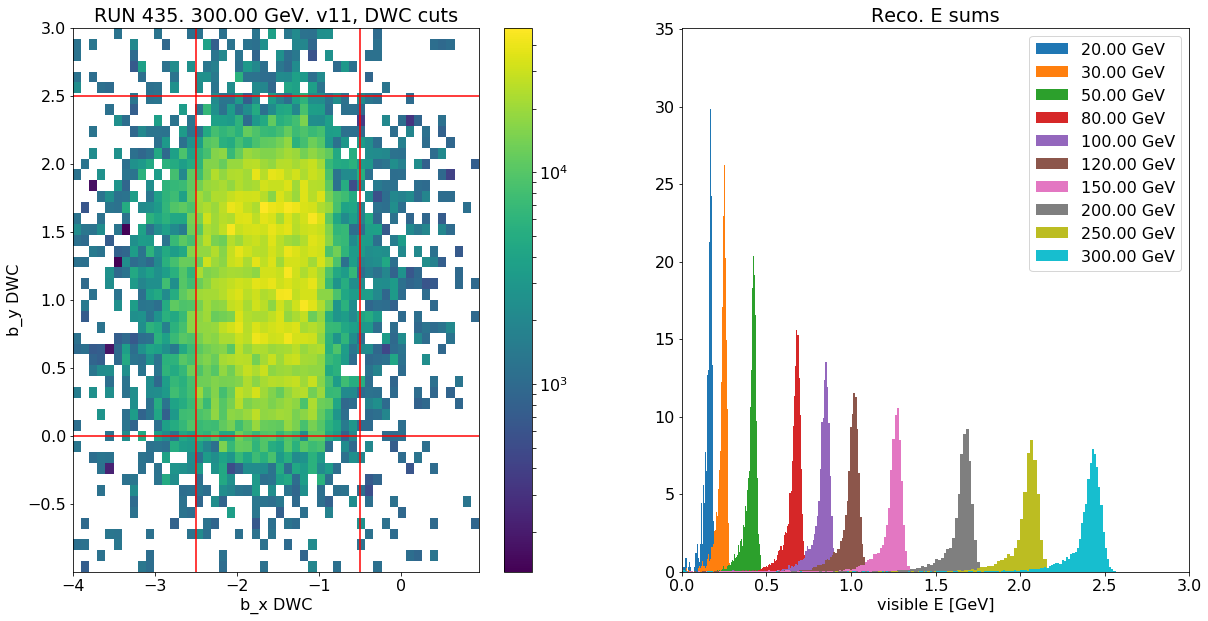

In [54]:
fig, (ax1,ax2) = plt.subplots(1, 2, figsize=(20, 10))
sel_en = ((df_v11[9].b_x > -4) & (df_v11[9].b_x < 1))
sel_en &= ((df_v11[9].b_y > -1) & (df_v11[9].b_y < 3))
# sel_en = ((df_v11[9].b_x > -4.5) & (df_v11[9].b_x < -1.5))
# sel_en &= ((df_v11[9].b_y > -0.5) & (df_v11[9].b_y < 2.5))
r=ax1.hist2d(df_v11[9][sel_en].b_x, df_v11[9][sel_en].b_y, 50, norm=LogNorm())
ax1.axvline(x = -2.5, color = 'red')
ax1.axvline(x = -0.5, color = 'red')
ax1.axhline(y = 0, color = 'red')
ax1.axhline(y = 2.5, color = 'red')
ax1.set_title('RUN %i. %.2f GeV. v11, DWC cuts' %(runs[9], energies[9]))
ax1.set_xlabel('b_x DWC')
ax1.set_ylabel('b_y DWC')
plt.colorbar(r[3], ax=ax1)
for i, energy in zip(range(len(runs)), energies):
    h = ax2.hist(sum_en_v11[i], density = 1, bins=200, label = '%.2f GeV' %energy)
ax2.set_title('Reco. E sums')
ax2.set_xlabel('visible E [GeV]')
plt.legend()
plt.xlim(0., 3.)

Text(0,0.5,'E visible [GeV]')

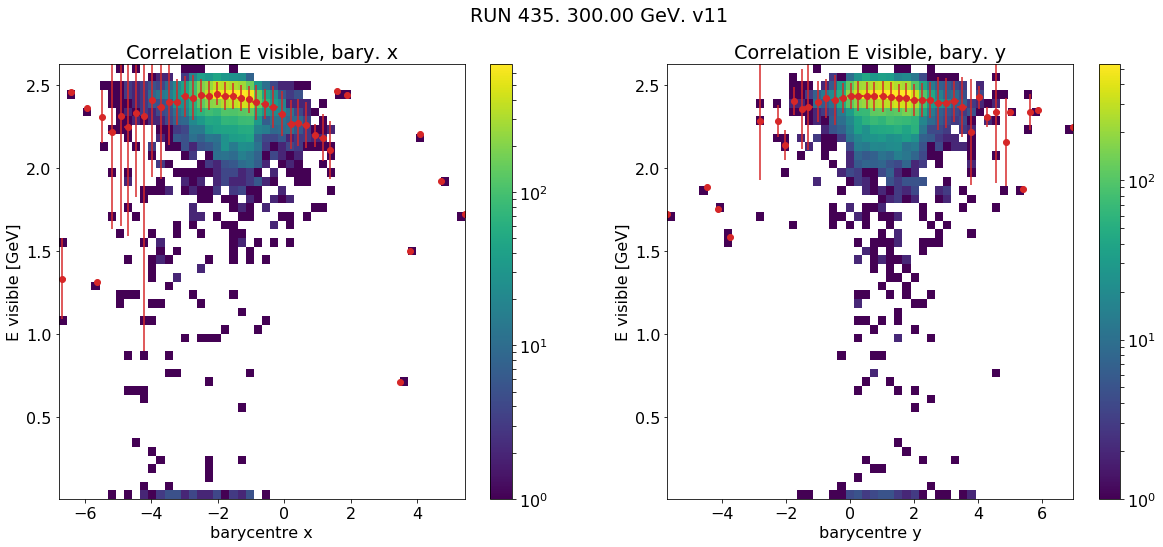

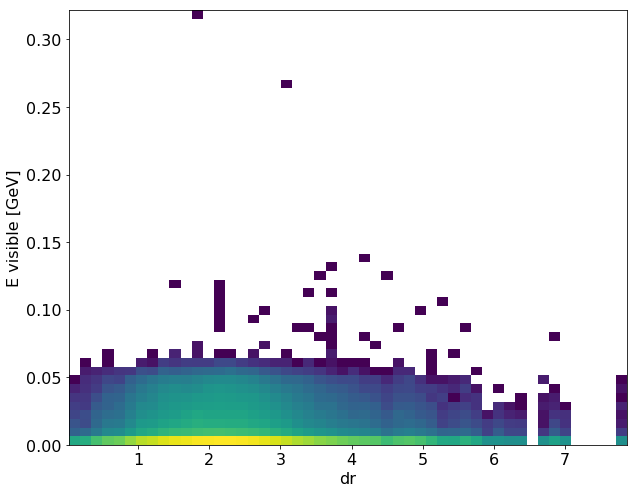

In [52]:
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(20, 8))
plt.suptitle('RUN %i. %.2f GeV. v11' %(runs[9], energies[9]))
df_v11[9]['Ex'] = df_v11[9].rechit_energy_w * df_v11[9].b_x
df_v11[9]['Ey'] = df_v11[9].rechit_energy_w * df_v11[9].b_y
sel_en = ((df_v11[9].b_x > -10) & (df_v11[9].b_x < 10))
sel_en &= ((df_v11[9].b_y > -10) & (df_v11[9].b_y < 10))

esums = df_v11[9][sel_en].groupby('event')['rechit_energy_w'].sum()
bary_x = df_v11[9][sel_en].groupby('event')['Ex'].sum()/esums
bary_y = df_v11[9][sel_en].groupby('event')['Ey'].sum()/esums
dx = df_v11[9][sel_en].b_x
dy = df_v11[9][sel_en].b_y
x_med, ex_med = binned_statistic(bary_x, [bary_x, esums], bins=50, statistic='median').statistic
x_iqr, ex_iqr = binned_statistic(bary_x, [bary_x, esums], bins=50, statistic=iqr).statistic
y_med, ey_med = binned_statistic(bary_y, [bary_y, esums], bins=50, statistic='median').statistic
y_iqr, ey_iqr = binned_statistic(bary_y, [bary_y, esums], bins=50, statistic=iqr).statistic

r=ax1.hist2d(bary_x, esums, 50, norm=LogNorm())
ax1.errorbar(x_med, ex_med, xerr=x_iqr, yerr=ex_iqr, marker='o', color='tab:red', linestyle='None')
ax1.set_title('Correlation E visible, bary. x')
ax1.set_xlabel('barycentre x')
ax1.set_ylabel('E visible [GeV]')
plt.colorbar(r[3], ax=ax1)

r=ax2.hist2d(bary_y, esums, 50, norm=LogNorm())
ax2.errorbar(y_med, ey_med, xerr=y_iqr, yerr=ey_iqr, marker='o', color='tab:red', linestyle='None')
ax2.set_title('Correlation E visible, bary. y')
ax2.set_xlabel('barycentre y')
ax2.set_ylabel('E visible [GeV]')
plt.colorbar(r[3], ax=ax2)

plt.figure(figsize=(10,8))
dr = np.hypot(dx,dy)
E  = df_v11[9][sel_en].rechit_energy_w/esums
r = plt.hist2d(dr, E, 50, norm = LogNorm())
plt.xlabel('dr')
plt.ylabel('E visible [GeV]')

In [ ]:
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(20, 8))
plt.suptitle('RUN %i. %.2f GeV. v8' %(runs[3], energies[3]))
df_v8[3]['Ex'] = df_v8[3].rechit_energy_w * df_v8[3].b_x
df_v8[3]['Ey'] = df_v8[3].rechit_energy_w * df_v8[3].b_y
sel_en = ((df_v8[3].b_x > -2) & (df_v8[3].b_x < 2))
sel_en &= ((df_v8[3].b_y > -1) & (df_v8[3].b_y < 2))

esums = df_v8[3][sel_en].groupby('event')['rechit_energy_w'].sum()
bary_x = df_v8[3][sel_en].groupby('event')['Ex'].sum()/esums
bary_y = df_v8[3][sel_en].groupby('event')['Ey'].sum()/esums

x_med, ex_med = binned_statistic(bary_x, [bary_x, esums], bins=50, statistic='median').statistic
x_iqr, ex_iqr = binned_statistic(bary_x, [bary_x, esums], bins=50, statistic=iqr).statistic
y_med, ey_med = binned_statistic(bary_y, [bary_y, esums], bins=50, statistic='median').statistic
y_iqr, ey_iqr = binned_statistic(bary_y, [bary_y, esums], bins=50, statistic=iqr).statistic

r=ax1.hist2d(bary_x, esums, 50, norm=LogNorm())
ax1.errorbar(x_med, ex_med, xerr=x_iqr, yerr=ex_iqr, marker='o', color='tab:red', linestyle='None')
ax1.set_title('Correlation E visible, bary. x')
ax1.set_xlabel('barycentre x')
ax1.set_ylabel('E visible [GeV]')
plt.colorbar(r[3], ax=ax1)

r=ax2.hist2d(bary_y, esums, 50, norm=LogNorm())
ax2.errorbar(y_med, ey_med, xerr=y_iqr, yerr=ey_iqr, marker='o', color='tab:red', linestyle='None')
ax2.set_title('Correlation E visible, bary. y')
ax2.set_xlabel('barycentre y')
ax2.set_ylabel('E visible [GeV]')
plt.colorbar(r[3], ax=ax2)

In [ ]:
plt.figure(figsize=(20,10))
plt.subplot(121)
plt.title('RUN %i. %i GeV.  Reco. E sums' %(runs[0], energies[0]))
# r=repeatedGausFit(sum_en_v11[0], 20)
r=plt.hist(sum_en_v11[0], density=1, color = 'tab:blue', bins=200)#, label=r'reco E v11. $\sigma = $ %.3f $E =$ %.3f' %(r[1], r[0]))

# r=repeatedGausFit(sum_en_v8[0], 20)
r=plt.hist(sum_en_v8[0], density=1, bins=200, color='darkorange')#, label=r'reco E v8. $\sigma = $ %.3f $E =$ %.3f' %(r[1], r[0]))

plt.legend()
plt.subplot(122)
plt.title('RUN %i. %i GeV.  Reco. E sums' %(runs[1], energies[1]))
# r=repeatedGausFit(sum_en_v11[1], 30)

r=plt.hist(sum_en_v11[1], density=1, color = 'tab:blue', bins=200)#, label=r'reco E v11. $\sigma = $ %.3f $E =$ %.3f' %(r[1], r[0]))
# r=repeatedGausFit(sum_en_v8[1], 30)

r=plt.hist(sum_en_v8[1], density=1, bins=200, color='darkorange')#, label=r'reco E v8. $\sigma = $ %.3f $E =$ %.3f' %(r[1], r[0]))

# plt.yscale('log')
plt.legend()

/cvmfs/sft.cern.ch/lcg/views/LCG_94/x86_64-centos7-gcc7-opt/lib/python2.7/site-packages/ipykernel/__main__.py:12: RuntimeWarning: divide by zero encountered in double_scalars
/cvmfs/sft.cern.ch/lcg/views/LCG_94/x86_64-centos7-gcc7-opt/lib/python2.7/site-packages/ipykernel/__main__.py:10: RuntimeWarning: overflow encountered in double_scalars
/cvmfs/sft.cern.ch/lcg/views/LCG_94/x86_64-centos7-gcc7-opt/lib/python2.7/site-packages/ipykernel/__main__.py:17: RuntimeWarning: invalid value encountered in multiply


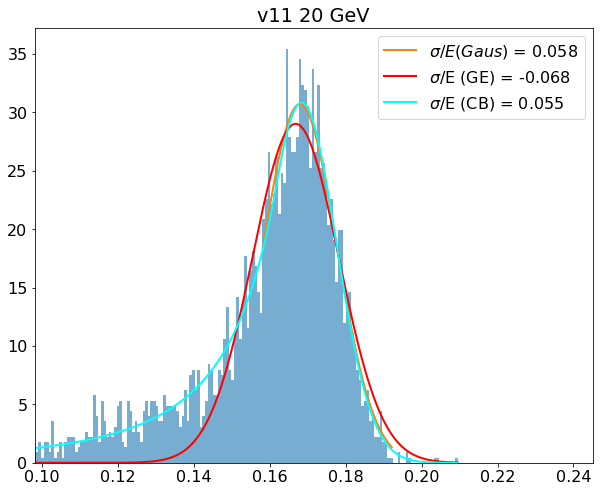

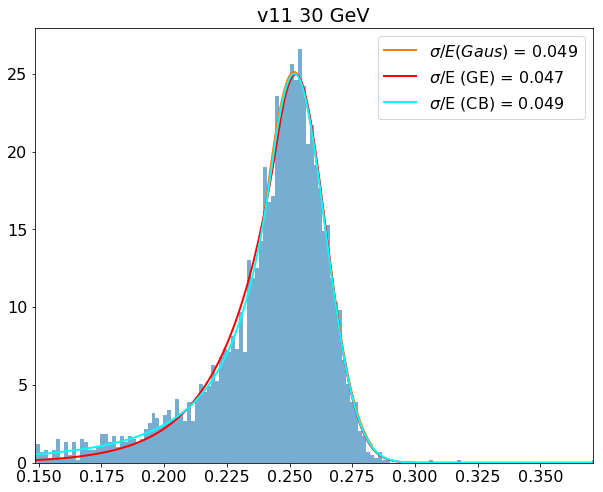

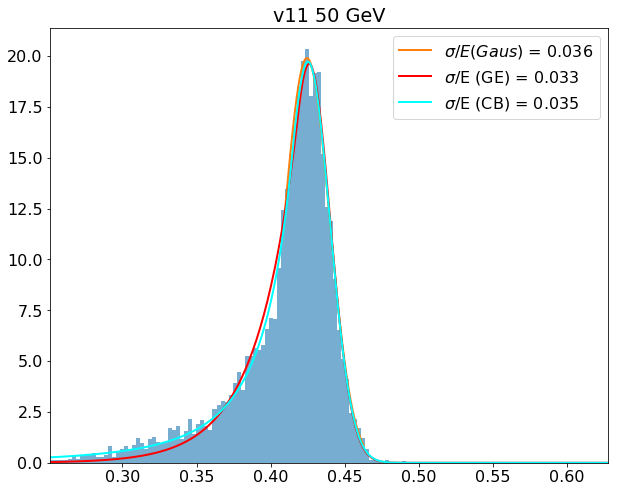

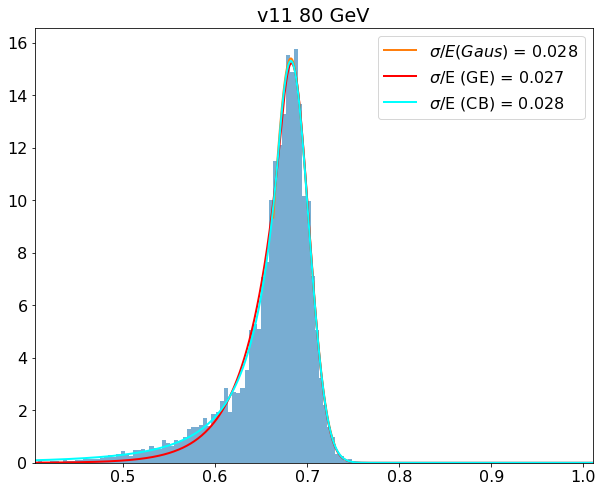

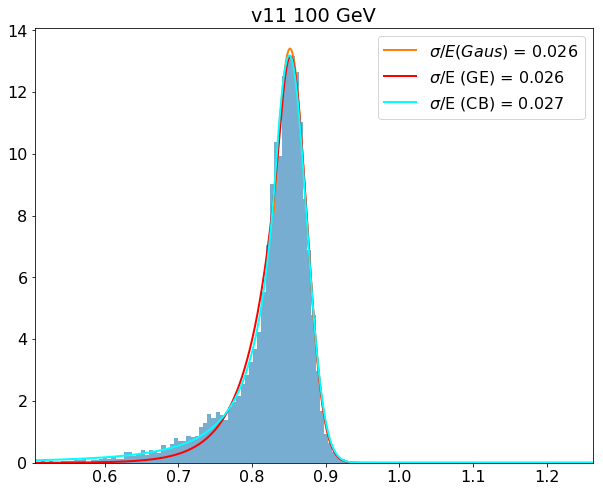

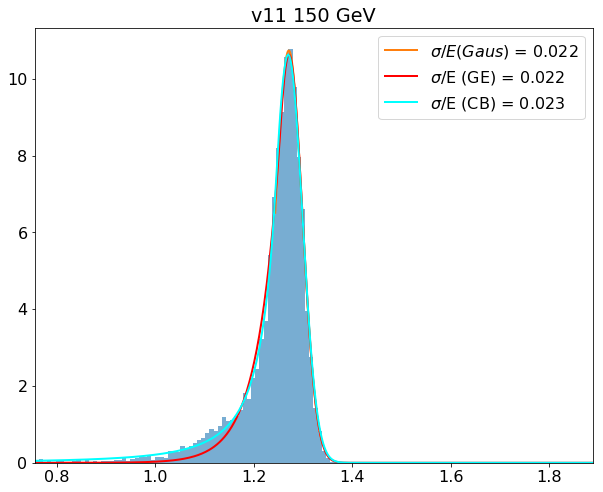

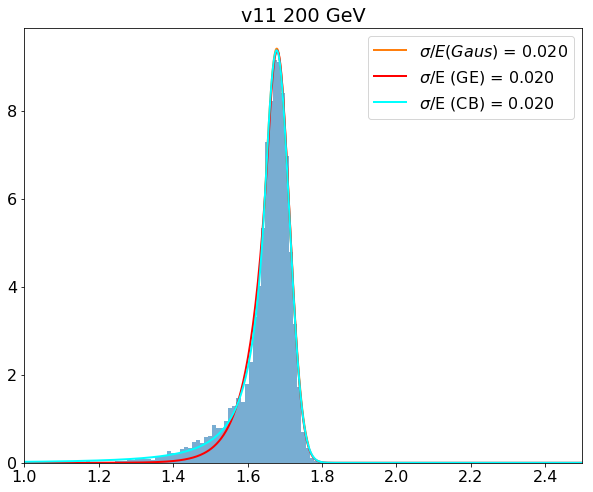

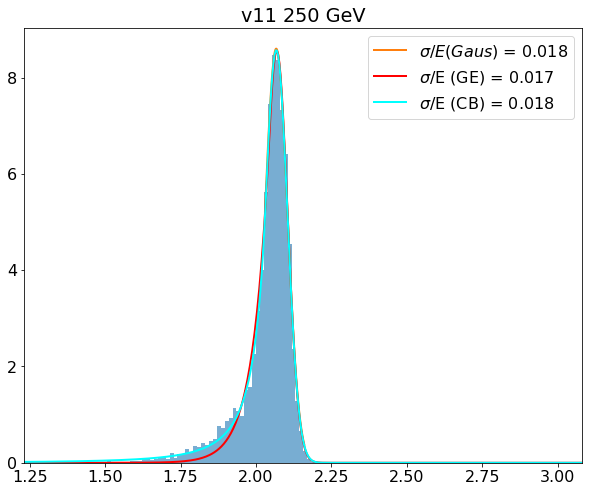

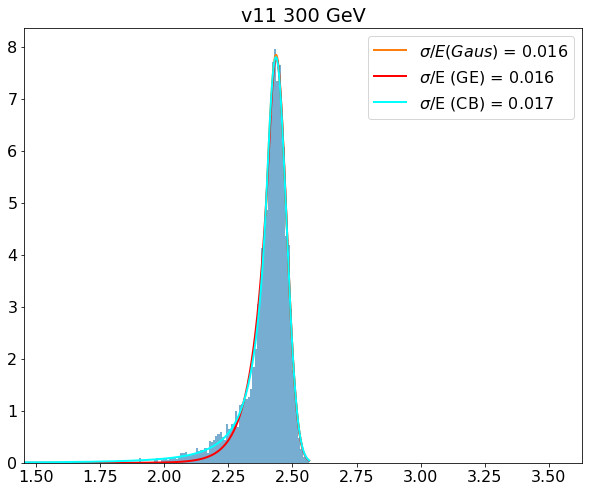

In [51]:
energies  = [20,  30,  50,  80,  100, 120, 150, 200, 250, 300]
resolution_gE = []; res_err_gE = []; MIP_gE = []
resolution_CB = []; res_err_CB = []; MIP_CB = []
resolution_G = []; res_err_G = []; MIP_G = []
# plt.figure(figsize=(20,10))


for sum_v11, energy in zip(sum_en_v11,energies):
    if energy == 120: continue
    plt.figure(figsize=(10,8))
    plt.title('v11 %i GeV' %energy)
    r2 = repeatedGausFit(sum_v11, energy)
    resolution_G.append(r2[1]/r2[0])
    error = err_prop(r2[1],r2[0],r2[3],r2[2])
    res_err_G.append(error)
    MIP_G.append(r2[0])
    
    r2 = GausExpFit(sum_v11, energy)
    resolution_gE.append(r2[0])
    res_err_gE.append(r2[2])
    MIP_gE.append(r2[1])

    r2 = CBFit(sum_v11, energy)
    resolution_CB.append(r2[0])
    res_err_CB.append(r2[2])
    MIP_CB.append(r2[1])
    plt.savefig('v11_cutsDWC_MultiFit_%iGeV.png' %energy)

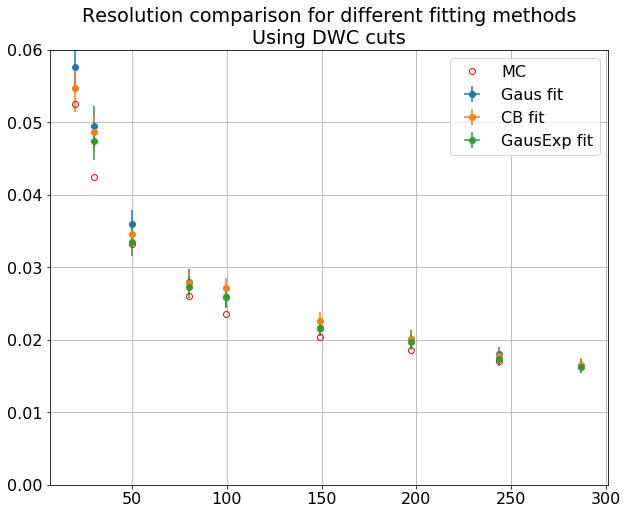

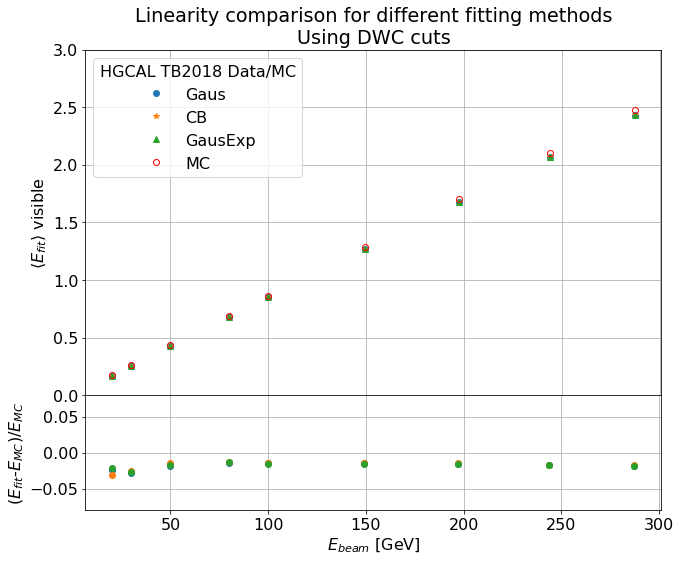

In [45]:
energies = [20, 30, 49.99, 79.93, 99.83, 119.65, 149.14, 197.32, 243.61, 287.18]
energies = [energy for energy in energies if (energy != 119.65)]
plt.figure(figsize=(10,8))
plt.title('Resolution comparison for different fitting methods' '\n' 'Using DWC cuts')

sys = np.asarray([0.05*res for res in resolution_G])
plt.errorbar(energies, np.asarray(resolution_G), xerr=0.002*np.asarray(energies), 
            yerr = np.sqrt(sys**2 + np.asarray(res_err_G)**2), marker = 'o', linestyle = 'None', label = 'Gaus fit')

sys = np.asarray([0.05*res for res in resolution_CB])
plt.errorbar(energies, np.asarray(resolution_CB), xerr=0.002*np.asarray(energies), 
            yerr = np.sqrt(sys**2 + np.asarray(res_err_CB)**2), marker = 'o', linestyle = 'None', label = 'CB fit')


sys = np.asarray([0.05*res for res in resolution_gE])
plt.errorbar(energies, np.asarray(resolution_gE), xerr=0.002*np.asarray(energies), 
            yerr = np.sqrt(sys**2 + np.asarray(res_err_gE)**2), marker = 'o', linestyle = 'None', label = 'GausExp fit')
plt.plot(energies, simul_reso, marker='o', mfc = 'None', linestyle='None', color='red', label ='MC')
plt.ylim(0, 0.06)
plt.legend()
plt.grid()
fig_1 = plt.figure(figsize=(10,8))
frame1 = fig_1.add_axes((.1,.3,.8,.6))
plt.title('Linearity comparison for different fitting methods' '\n' 'Using DWC cuts')
plt.plot(energies, MIP_G, 'o', label = 'Gaus')
plt.plot(energies, MIP_CB, '*', label = 'CB')
plt.plot(energies, MIP_gE, '^', label = 'GausExp')
plt.plot(energies, E_MC, marker='o', linestyle='None', mfc = 'None', color='red', label = 'MC')

plt.ylabel(r'$\left\langle E_{fit} \right\rangle$ visible')
plt.ylim(0., 3.)
plt.grid()
plt.legend(title = 'HGCAL TB2018 Data/MC')
frame1.set_xticklabels([])
frame2=fig_1.add_axes((.1,.1,.8,.2)) 
diff_GE = (np.asarray(MIP_gE)-np.asarray(E_MC))/np.asarray(E_MC)
diff_CB = (np.asarray(MIP_CB)-np.asarray(E_MC))/np.asarray(E_MC)
diff_Gaus = (np.asarray(MIP_G)-np.asarray(E_MC))/np.asarray(E_MC)


plt.errorbar(energies, diff_Gaus, xerr=0.002*np.asarray(energies), yerr=0, 
             marker='o', linestyle='None',label='<E> res. Gaus')
plt.errorbar(energies, diff_GE, xerr=0.002*np.asarray(energies), yerr=0, 
             marker='o', linestyle='None',label='<E> res. GausExp')
plt.errorbar(energies, diff_CB, xerr=0.002*np.asarray(energies), yerr=0, 
             marker='o', linestyle='None',label='<E> res. Crystal Ball')
plt.ylabel(r'$\left\langle E\right\rangle$ [MIP]')

plt.xlabel(r'$E_{beam}$ [GeV]')
plt.ylabel(r'($E_{fit}$-$E_{MC}$)/$E_{MC}$')
plt.ylim(-0.08, 0.08)
plt.grid()

In [ ]:
resolution_new = []; resolution_old = []; en_fit = []; res_err_new = []; res_err_old = []; e_lin = []; e_lin_old=[]
MIP_new = []; MIP_old = []; err_MIP_new = []; err_MIP_old = []
energies  = [20,  30,  50,  80,  100, 120, 150, 200, 250, 300]
resolution_11 = []; res_err_11 = []; MIP_11 = []
plt.figure(figsize=(20,10))
# plt.subplot(121)
# plt.title('v9 fits')
# for sum_v9, energy in zip(sum_en_v9, energies):
#     if energy == 120: continue
#     r2 = repeatedGausFit(sum_v9, energy)
#     resolution_new.append(r2[1]/r2[0])
#     error = err_prop(r2[1],r2[0],r2[3],r2[2])
#     res_err_new.append(error)
#     MIP_new.append(r2[0])
# plt.xlabel('E sum [GeV]')

plt.subplot(121)
plt.title('v8 fits')
for sum_v8, energy in zip(sum_en_v8,energies):
#     plt.figure(figsize=(10,8))
    if energy == 120: continue
    r2 = repeatedGausFit(sum_v8, energy)
#     plt.title('Data (v8) %i GeV' %energy)
#     a = plt.hist(sum_v8, bins=300, normed=1)
    resolution_old.append(r2[1]/r2[0])
    error = err_prop(r2[1],r2[0],r2[3],r2[2])
    res_err_old.append(error)
    MIP_old.append(r2[0])
plt.xlim(0., 3.0)

plt.subplot(122)
plt.title('v11 fits')
for sum_v11, energy in zip(sum_en_v11,energies):
    if energy == 120: continue
    r2 = repeatedGausFit(sum_v11, energy)
    resolution_11.append(r2[1]/r2[0])
    error = err_prop(r2[1],r2[0],r2[3],r2[2])
    res_err_11.append(error)
    MIP_11.append(r2[0])    

In [ ]:
resolution_11 = [0.05509654028934182,
 0.048416831183358836,
 0.036802084835793086,
 0.030230580062532198,
 0.027763607459974998,
 0.022211176199090948,
 0.02041216657438586,
 0.018305488347147493,
 0.01724068354471974]

In [ ]:
res_err_11 = [0.001038942172852401,
 0.0010491398030856168,
 0.0009532104540543196,
 0.0008421136042935656,
 0.0009105000867031456,
 0.0005300965539583607,
 0.0005066785701384369,
 0.00037238852587587624,
 0.000592254750896224]

In [ ]:
MIP_11 =[0.16928161145257495,
 0.2531743242030127,
 0.4251338470661471,
 0.6816991088977058,
 0.8510718944104344,
 1.2707809023945833,
 1.6780642077063601,
 2.066967093295746,
 2.444514904087021]

In [ ]:
resolution_old = [0.05246849411574991,
 0.04356579361980387,
 0.03632208007443212,
 0.029958395913805447,
 0.02530352238094564,
 0.022427495545102396,
 0.0187401627143027,
 0.017819044938413693,
 0.016865872898028156]

In [ ]:
res_err_old = [0.0014072224607638963,
 0.001124067458120093,
 0.0008543703439377619,
 0.0008318049333382934,
 0.0009267709664638018,
 0.0009136234433585624,
 0.0007944884503405302,
 0.0003716883142259822,
 0.000785111101665239]

In [ ]:
MIP_old = [0.17353610429150784,
 0.25847092741828015,
 0.4319115554318758,
 0.690278299772658,
 0.8586427611874371,
 1.2814253028723628,
 1.6856248528595612,
 2.067077924249674,
 2.42826522259055]

In [ ]:
energies = [20, 30, 49.99, 79.93, 99.83, 119.65, 149.14, 197.32, 243.61, 287.18]
energies = [energy for energy in energies if (energy != 119.65)]

In [ ]:
plt.figure(figsize=(10,8))
sys_old = [0.05*res for res in resolution_old]
plt.errorbar(energies, np.asarray(resolution_old), xerr=0.002*np.asarray(energies), 
             yerr=np.sqrt(np.asarray(res_err_old)**2+np.asarray(sys_old)**2), marker='o', linestyle='None',label='Data v8')

# popt, pcov = curve_fit(E_res, energies, np.asarray(resolution_old))
# plt.plot(energies, E_res(energies, *popt), '-.', label='Stoc. = %.2f, N = %.2f, C = %.2f' %(popt[0], popt[1], popt[2]))
# print popt, np.sqrt(np.diag(pcov))

sys_11 = [0.05*res for res in resolution_11]
plt.errorbar(energies, np.asarray(resolution_11), xerr=0.002*np.asarray(energies), 
             yerr=np.sqrt(np.asarray(res_err_11)**2+np.asarray(sys_11)**2), marker='o', linestyle='None',label=' Data v11')

# popt, pcov = curve_fit(E_res, energies, resolution_11, p0=[ 2.5e-01,  1.3e-05, -9.6e-03])
# plt.plot(energies, E_res(energies, *popt), '-.', label='Stoc. = %.2f, N = %.2f, C = %.2f' %(popt[0], popt[1], popt[2]))
# print popt, pcov

plt.plot(energies, simul_reso, 'o', mfc='None', color='red',label = 'MC')
# popt, pcov = curve_fit(E_res, energies, simul_reso)
# plt.plot(energies, E_res(energies, *popt), '-.', label='Stoc. = %.2f, N = %.2f, C = %.2f' %(popt[0], popt[1], popt[2]))
# print popt, np.sqrt(np.diag(pcov))

plt.title('Resolution comparison w/ new DWC cuts')
plt.legend(title = 'HGCAL TB2018 Data/MC')
plt.xlabel(r'$E_{beam}$ [GeV]')
plt.ylabel(r'Gaus $\sigma$/$\left\langle E\right\rangle$')
plt.grid()
plt.ylim(0., 0.06)

In [ ]:
fig_1 = plt.figure(figsize=(10,8))
frame1 = fig_1.add_axes((.1,.3,.8,.6))
plt.title('Linearity comparison w/ new DWC cuts')

plt.errorbar(energies, MIP_old, xerr=0.002*np.asarray(energies), yerr=0, 
             marker='^', linestyle='None',label='Data v8')
plt.errorbar(energies, MIP_11, xerr=0.002*np.asarray(energies), yerr=0, 
             marker='^', linestyle='None',label='Data v11')
plt.errorbar(energies, E_MC, xerr=0.002*np.asarray(energies), yerr=0, 
             marker='o', color='red', mfc='None',linestyle='None',label='MC')

plt.legend(title = 'HGCAL TB2018 Data/MC')

plt.ylabel(r'$\left\langle E_{fit} \right\rangle$ visible')
plt.ylim(0., 3.)
plt.grid()
frame1.set_xticklabels([])
frame2=fig_1.add_axes((.1,.1,.8,.2))       
diff_v8 = (np.asarray(MIP_old)-np.asarray(E_MC))/np.asarray(E_MC)
diff_v11 = (np.asarray(MIP_11)-np.asarray(E_MC))/np.asarray(E_MC)

plt.errorbar(energies, diff_v8, xerr=0.002*np.asarray(energies), yerr=0, 
             marker='o', linestyle='None',label='<E> res. v8')
plt.errorbar(energies, diff_v11, xerr=0.002*np.asarray(energies), yerr=0, 
             marker='o', linestyle='None',label='<E> res. v11')
plt.ylabel(r'$\left\langle E\right\rangle$ [MIP]')
plt.legend(title = 'HGCAL TB2018 Data/MC')
plt.xlabel(r'$E_{beam}$ [GeV]')
plt.ylabel(r'($E_{fit}$-$E_{MC}$)/$E_{MC}$')
plt.ylim(-0.08, 0.08)
plt.grid()
plt.legend(ncol=2)

In [ ]:
plt.figure(figsize=(10,8))
# sys_new = [0.05*res for res in resolution_new]

# plt.errorbar(energies, np.asarray(resolution_new), xerr=0.002*np.asarray(energies), 
#              yerr=np.sqrt(np.asarray(res_err_new)**2+np.asarray(sys_new)**2), marker='o', linestyle='None',label=' Data v9')
# plt.errorbar(79.93, res_v9_470, xerr=[0.002*79.93],yerr=[err_v9_470], marker='o', linestyle='None',label='467 v9')
sys_old = [0.05*res for res in resolution_old]
plt.errorbar(energies, np.asarray(resolution_old), xerr=0.002*np.asarray(energies), 
             yerr=np.sqrt(np.asarray(res_err_old)**2+np.asarray(sys_old)**2), marker='o', linestyle='None',label='Data')
# plt.errorbar(79.93, res_v8_470, xerr=[0.002*79.93], yerr=[err_v8_470], marker='o', linestyle='None',label='467 v8')
plt.plot(energies, simul_reso, 'o', mfc='None', color='red',label = 'MC')
plt.legend(title = 'HGCAL TB2018 Data/MC')
plt.xlabel(r'$E_{beam}$ [GeV]')
plt.ylabel(r'Gaus $\sigma$/$\left\langle E\right\rangle$')
plt.grid()
plt.ylim(0., 0.06)

In [ ]:
fig1 = plt.figure(figsize=(10,8))
frame1=fig1.add_axes((.1,.3,.8,.6))
# plt.title('Reco. energy linearity from rechit_energy')#\n Using median and IQR')
# diff_v9 = (np.asarray(MIP_new)-np.asarray(E_MC))/np.asarray(E_MC)
# plt.errorbar(energies, diff_v9, xerr=0.002*np.asarray(energies), yerr=0, 
#              marker='o', linestyle='None',label='v9')
diff_v8 = (np.asarray(MIP_old)-np.asarray(E_MC))/np.asarray(E_MC)

plt.errorbar(energies, diff_v8, xerr=0.002*np.asarray(energies), yerr=0, 
             marker='o', linestyle='None',label='Data')

plt.ylabel(r'$\left\langle E\right\rangle$ [MIP]')
plt.legend(title = 'HGCAL TB2018 Data/MC')

plt.xlabel(r'$E_{beam}$ [GeV]')
plt.ylabel(r'($E_{fit}$-$E_{MC}$)/$E_{MC}$')
plt.ylim(-0.08, 0.08)
plt.grid()

In [ ]:
fig1 = plt.figure(figsize=(10,8))
frame1=fig1.add_axes((.1,.3,.8,.6))
# plt.title('Reco. energy linearity from rechit_energy')#\n Using median and IQR')
# plt.errorbar(energies, E_new, xerr=0.002*np.asarray(energies), yerr=0, 
#              marker='o', linestyle='None',label='v9')

plt.errorbar(energies, MIP_old, xerr=0.002*np.asarray(energies), yerr=0, 
             marker='^', linestyle='None',label='Data')

plt.errorbar(energies, E_MC, xerr=0.002*np.asarray(energies), yerr=0, 
             marker='o', color='red', mfc='None',linestyle='None',label='MC')

plt.legend(title = 'HGCAL TB2018 Data/MC')

plt.xlabel(r'$E_{beam}$ [GeV]')
plt.ylabel(r'$\left\langle E_{fit} \right\rangle$ visible')
plt.ylim(0., 3.)
plt.grid()

In [ ]:
fig_1 = plt.figure(figsize=(10,8))
frame1 = fig_1.add_axes((.1,.3,.8,.6))
plt.errorbar(energies, MIP_old, xerr=0.002*np.asarray(energies), yerr=0, 
             marker='^', linestyle='None',label='Data')

plt.errorbar(energies, E_MC, xerr=0.002*np.asarray(energies), yerr=0, 
             marker='o', color='red', mfc='None',linestyle='None',label='MC')

plt.legend(title = 'HGCAL TB2018 Data/MC')

# plt.xlabel(r'$E_{beam}$ [GeV]')
plt.ylabel(r'$\left\langle E_{fit} \right\rangle$ visible')
plt.ylim(0., 3.)
plt.grid()
frame1.set_xticklabels([])
frame2=fig_1.add_axes((.1,.1,.8,.2))       
diff_v8 = (np.asarray(MIP_old)-np.asarray(E_MC))/np.asarray(E_MC)

plt.errorbar(energies, diff_v8, xerr=0.002*np.asarray(energies), yerr=0, 
             marker='o', linestyle='None',label='<E> res.')

plt.ylabel(r'$\left\langle E\right\rangle$ [MIP]')
plt.legend(title = 'HGCAL TB2018 Data/MC')

plt.xlabel(r'$E_{beam}$ [GeV]')
plt.ylabel(r'($E_{fit}$-$E_{MC}$)/$E_{MC}$')
plt.ylim(-0.08, 0.08)
plt.grid()
plt.legend()

<h1> Resolution comparison flagging noisy cells </h1>

In [ ]:
%%time

# 80 GeV runs
_80GeV = range(466, 476)
_100GeV = range(477, 492)
_150GeV = range(493, 510)#range(303, 319) + range(337, 361) + range(493, 510)
run_real = []
df_v8 = []
for run in _150GeV:
    try:
        df_v8.append(add_dwc(run, v8_prefix, 8))
        run_real.append(run)
    except IOError:
        continue

In [ ]:
%%time
sum_en_v8 = []
for df in df_v8:
    sum_en_v8.append(do_Esum(df))

In [ ]:
%%time
#Create E sums flagging noisy cells
sum_en_v8_NF = []
for df in df_v8:
    sum_en_v8_NF.append(do_Esum_Noise(df))

In [ ]:
resolution_old = []; res_err_old = []; MIP_old = []
resolution_old_NF = []; res_err_old_NF = []; MIP_old_NF = []
Es = []; sigmas = []
energies  = [20,  30,  50,  80,  100, 120, 150, 200, 250, 300]

for sum_v8 in sum_en_v8:
    energy = 150
#     if energy == 20: continue
    r2 = repeatedGausFit(sum_v8, energy)
    resolution_old.append(r2[1]/r2[0])
    Es.append(r2[0])
    sigmas.append(r2[1])
    error = err_prop(r2[1],r2[0],r2[3],r2[2])
    res_err_old.append(error)
    MIP_old.append(r2[0])

for sum_v8 in sum_en_v8_NF:
    energy = 150
#     if energy == 20: continue
    r2 = repeatedGausFit(sum_v8, energy)
    resolution_old_NF.append(r2[1]/r2[0])
    error = err_prop(r2[1],r2[0],r2[3],r2[2])
    res_err_old_NF.append(error)
    MIP_old_NF.append(r2[0])

In [ ]:
import itertools
from collections import defaultdict

resos = defaultdict(list)
for i in range(len(sum_en_v8)):
    resos[i].append(sum_en_v8[i])

In [ ]:
for i in range(len(sum_en_v8)):
    ss = pd.Series(list(itertools.chain.from_iterable(resos[i])))

In [ ]:
r = repeatedGausFit(ss, 150)
print r[1]/r[0]

In [ ]:
plt.figure(figsize=(10,8))

sys_old = [0.05*res for res in resolution_old]
plt.errorbar(run_real, np.asarray(resolution_old), xerr=0, 
             yerr=np.sqrt(np.asarray(res_err_old)**2+np.asarray(sys_old)**2), marker='o', linestyle='None',label='Data')

sys_old_NF = [0.05*res for res in resolution_old_NF]
plt.errorbar(run_real, np.asarray(resolution_old_NF), xerr=0,
             yerr=np.sqrt(np.asarray(res_err_old_NF)**2+np.asarray(sys_old_NF)**2), marker='o', linestyle='None',label='Data (no noisy cells)')

# plt.plot(energies, simul_reso, 'o', mfc='None', color='red',label = 'MC')
plt.xlabel(r'Run ID')
plt.ylabel(r'Gaus $\sigma$/$\left\langle E\right\rangle$')
plt.grid()
# plt.axvline(x=466, color='red', linestyle = '-.')
# plt.axvline(x=472, color='red', linestyle = '-.')
# plt.axvline(x=468, color='red', linestyle = '-.')
plt.axhline(y=0.020451829612688918, color='green', linestyle='--', label='MC res.')
plt.axhline(y=resolution_old[1], color='red', linestyle='-.', label='Run 494 res.')
plt.axhline(y=np.median(resolution_old), color='purple', linestyle='-.', label='median 150GeV res.')
plt.axhline(y=np.mean(resolution_old), color='cyan', linestyle='-.', label='mean 150GeV res.')
plt.axhline(y=0.022761034755404596, color='black', linestyle='-', label='150GeV res. combined')

plt.legend(title = 'HGCAL TB2018 Data, 150GeV', ncol=2)
plt.title('150GeV runs 493-509 (with DWC)')
plt.ylim(0.015, 0.03)

<h1> Shower profiles and comparison </h1>

In [ ]:
branches = [u'event', 
       u'rechit_layer','rechit_module', u'rechit_chip', u'rechit_channel', u'rechit_x', u'rechit_y', u'rechit_z',
       u'rechit_energy', u'rechit_amplitudeHigh', u'rechit_amplitudeLow', u'rechit_Tot', 'rechit_toaRise',
       'rechit_TS3High','rechit_TS3Low',  'rechit_TS2High','rechit_TS2Low']

rh_branches = [branch for branch in branches if "rechit" in branch]

# Adding entries in df for energy bary. components calculation
def do_df(run, v_prefix):
    fname = v_prefix + "ntuple_%i.root" %run
    df = read_root(fname,key='rechitntupler/hits',columns = branches, flatten = rh_branches)
    df['e_w'] = df['rechit_energy']*MIPtoGeV#(df['rechit_layer'].map(weights)+df['rechit_layer'].map(weights)*MIPtoGeV)
    df['lay_X0'] = df['rechit_layer'].map(lay_X0)
    
    df['Ex'] = df.rechit_energy * df.rechit_x
    df['Ey'] = df.rechit_energy * df.rechit_y
    df['Ez'] = df.rechit_energy * df.rechit_z
    
    return df

In [ ]:
def eProf(df):
    sel = (df.rechit_energy>0.5) #& (df.rechit_layer < 28)
    sel &= ~((df.rechit_chip == 3) & (df.rechit_channel == 22)) 
    df_sel = df[sel]
    e_sum = df_sel.groupby('event')['e_w'].sum()
    lay_sum = df_sel.groupby(['event','lay_X0'])['e_w'].sum()
    
    e_frac = (lay_sum/e_sum).reset_index().groupby('lay_X0')['e_w'].mean()
    e_lay = df_sel.groupby('lay_X0')['e_w'].size()

    xbar = df_sel.groupby('event')['Ex'].sum()/e_sum
    ybar = df_sel.groupby('event')['Ey'].sum()/e_sum
    zbar = df_sel.groupby('event')['Ez'].sum()/e_sum
    
    bary = [xbar, ybar, zbar]
    
    return lay_sum, e_lay, bary

In [ ]:
from scipy.special import gamma
def eShow(t, E, a, b):
    return E*((b*t)**(a-1)*b*np.exp(-b*t))/gamma(a)

In [ ]:
energies  = [20,  30,  50,  80,  100, 120, 150, 200, 250, 300]
runs      = [452, 607, 457, 467, 477, 621, 496, 664, 653, 420]
eFracs = []
for i in range(len(runs)):
    run = runs[i]
    print energies[i],
    df = do_df(run, v9_prefix)
    
    shower = eProf(df)
    eFracs.append(shower[0])

In [ ]:
plt.figure(figsize=(20,10))
for i in range(len(eFracs)):
    energy = energies[i]
    plt.plot(eFracs[i].index, eFracs[i], 'o--', alpha=0.6, label = '%i GeV' %energy)
    sel = eFracs[i].index < 28
    popt, pcov = curve_fit(eShow, eFracs[i].index, eFracs[i])

    T = (popt[0]-1)/popt[1]
    t = popt[1]/popt[0]
    E_c = 40.19*1e-3
    eT = np.exp(T)
#     plt.axvline(x=T, color='red')
    E_beam = eT*E_c
    print E_beam
    plt.plot(eFracs[i].index, eShow(eFracs[i].index, *popt), linewidth=2, label = r'$E_{fit}$ = %i GeV' %E_beam)

    
plt.legend()

In [ ]:
dd = do_df(1008, v11_prefix)

In [ ]:
e11 = eProf(dd)

In [ ]:
plt.plot(e11[0][3279].index, e11[0][3279], 'o--')
sel = (e11[0][3279].index < 29) 
popt, pcov = curve_fit(eShow, e11[0][3279][sel].index, e11[0][3279][sel])
plt.plot(e11[0][3279].index, eShow(e11[0][3279].index, *popt))
print popt[0]#*MIPtoGeV

In [ ]:
# Create df for ntuples
run = 672

df_v9 = do_df(run, v9_prefix); df_v8 = do_df(run, v8_prefix)

In [ ]:
etot_v9 = df_v9.groupby('event').e_w.sum(); etot_v8 = df_v8.groupby('event').e_w.sum()

e_v9 = eProf(df_v9); e_v8 = eProf(df_v8)
eFrac_v9 = e_v9[0]; eFrac_v8 = e_v8[0]
eLay_v9 = e_v9[1]; eLay_v8 = e_v8[1]
bar_v9 = e_v9[2]; bar_v8 = e_v8[2]

In [ ]:
# Energy fraction profiles comparison
plt.figure(figsize=(20, 10))
plt.subplot(121)
plt.title('RUN %i' %run)
plt.plot(eFrac_v9.index, eFrac_v9, 'o-', label = 'v9')
plt.plot(eFrac_v8, '^-', label = 'v8')

plt.xlabel('Layer [X0]')
plt.ylabel(r'$E_{dep}/Lay.$')
plt.legend()

plt.subplot(122)
plt.title('RUN %i' %run)
plt.plot(eLay_v9, 'o-', label = 'v9')
plt.plot(eLay_v8, '^-', label = 'v8')
plt.xlabel('Layer [X0]')
plt.ylabel(r'E/Lay.')
plt.legend()

In [ ]:
z_med_v9, e_med_v9 = binned_statistic(bar_v9[2], [bar_v9[2], etot_v9], bins=50, statistic='median').statistic
z_iqr_v9, e_iqr_v9 = binned_statistic(bar_v9[2], [bar_v9[2], etot_v9], bins=50, statistic=iqr).statistic
z_med_v8, e_med_v8 = binned_statistic(bar_v8[2], [bar_v8[2], etot_v8], bins=50, statistic='median').statistic
z_iqr_v8, e_iqr_v8 = binned_statistic(bar_v8[2], [bar_v8[2], etot_v8], bins=50, statistic=iqr).statistic

plt.figure(figsize = (30, 20))
plt.subplot(221)
plt.title('Shower profile v9. RUN %i' %run)
r =plt.hist2d(bar_v9[2], etot_v9, 50, cmap = 'viridis', norm = LogNorm())

plt.plot(z_med_v9, e_med_v9, 'ko', color='red')
plt.xlabel('bary z')
plt.ylabel('E sum')

plt.subplot(222)
plt.title('Shower profile v8. RUN %i' %run)
r =plt.hist2d(bar_v8[2], etot_v8, 50, cmap = 'viridis', norm = LogNorm())

plt.plot(z_med_v8, e_med_v8, 'ko', color='red')
plt.xlabel('bary z')
plt.ylabel('E sum [GeV]')

sel = df_v9.rechit_layer < 29
bary_z_EE_v9 = df_v9[sel].groupby('event')['Ez'].sum()/etot_v9
sel = df_v8.rechit_layer < 29
bary_z_EE_v8 = df_v8[sel].groupby('event')['Ez'].sum()/etot_v8

z_med_v9_EE, e_med_v9_EE = binned_statistic(bary_z_EE_v9, [bary_z_EE_v9, etot_v9], bins=50, statistic='median').statistic
z_med_v8_EE, e_med_v8_EE = binned_statistic(bary_z_EE_v8, [bary_z_EE_v8, etot_v8], bins=50, statistic='median').statistic
z_iqr_v9_EE, e_iqr_v9_EE = binned_statistic(bary_z_EE_v9, [bary_z_EE_v9, etot_v9], bins=50, statistic=iqr).statistic
z_iqr_v8_EE, e_iqr_v8_EE = binned_statistic(bary_z_EE_v8, [bary_z_EE_v8, etot_v8], bins=50, statistic=iqr).statistic

plt.subplot(223)
plt.title('Shower profile in EE v9. RUN %i' %run)
r =plt.hist2d(bary_z_EE_v9, etot_v9, 50, cmap = 'viridis', norm = LogNorm())

plt.plot(z_med_v9_EE, e_med_v9_EE, 'ko', color='red')
plt.xlabel('bary z')
plt.ylabel('E sum [GeV]')

plt.subplot(224)
plt.title('Shower profile in EE v8. RUN %i' %run)
r =plt.hist2d(bary_z_EE_v8, etot_v8, 50, cmap = 'viridis', norm = LogNorm())

plt.plot(z_med_v8_EE, e_med_v8_EE, 'ko', color='red')
plt.xlabel('bary z')
plt.ylabel('E sum [GeV]')

In [ ]:
plt.figure(figsize=(20,10))
plt.subplot(121)
plt.title('Shower energy deposit profile. RUN %i' %run)
plt.errorbar(z_med_v9, e_med_v9, xerr=z_iqr_v9, yerr=e_iqr_v9, marker='o', linestyle='None', label = 'v9')
plt.errorbar(z_med_v8, e_med_v8, xerr=z_iqr_v8, yerr=e_iqr_v8, marker='o', linestyle='None', label = 'v8')
plt.xlabel(r'$\left\langle bary. z\right\rangle$')
plt.ylabel(r'$\left\langle E sum\right\rangle$')
plt.legend()

plt.subplot(122)
plt.title('Shower energy deposit profile in EE. RUN %i' %run)

plt.errorbar(z_med_v9_EE, e_med_v9_EE, xerr=z_iqr_v9_EE, yerr=e_iqr_v9_EE, marker='o', linestyle='None', label = 'v9')
plt.errorbar(z_med_v8_EE, e_med_v8_EE, xerr=z_iqr_v8_EE, yerr=e_iqr_v8_EE, marker='o', linestyle='None', label = 'v8')
plt.xlabel(r'$\left\langle bary. z\right\rangle$')
plt.ylabel(r'$\left\langle E sum\right\rangle$')
plt.legend()


In [ ]:
v9_layer = df_v9.groupby(['event']).lay_X0.mean()
v8_layer = df_v8.groupby(['event']).lay_X0.mean()

v9_lay_med, e_v9_med = binned_statistic(v9_layer, [v9_layer, etot_v9], bins=50, statistic='median').statistic
v8_lay_med, e_v8_med = binned_statistic(v8_layer, [v8_layer, etot_v8], bins=50, statistic='median').statistic
v9_lay_iqr, e_v9_iqr = binned_statistic(v9_layer, [v9_layer, etot_v9], bins=50, statistic=iqr).statistic
v8_lay_iqr, e_v8_iqr = binned_statistic(v8_layer, [v8_layer, etot_v8], bins=50, statistic=iqr).statistic

plt.figure(figsize=(20, 10))
plt.subplot(121)
plt.title('Energy deposit per layer profile, v9. RUN %i' %run)
r =plt.hist2d(v9_layer, etot_v9, 50, cmap = 'viridis', norm = LogNorm())
plt.plot(v9_lay_med, e_v9_med, 'ko', color='red')

plt.xlabel('Layer')
plt.ylabel('E sum [GeV]')

plt.subplot(122)
plt.title('Energy deposit per layer profile, v8. RUN %i' %run)
r =plt.hist2d(v8_layer, etot_v8, 50, cmap = 'viridis', norm=LogNorm())
plt.plot(v8_lay_med, e_v8_med, 'ko', color='red')

plt.xlabel('Layer')
plt.ylabel('E sum [GeV]')

In [ ]:
plt.figure(figsize=(10,8))
plt.title('Energy per layer profiles. RUN %i' %run)
plt.errorbar(v9_lay_med, e_v9_med, xerr=v9_lay_iqr, yerr=e_iqr_v9, marker='o', linestyle = 'None', label = 'v9')
plt.errorbar(v8_lay_med, e_v8_med, xerr=v8_lay_iqr, yerr=e_iqr_v8, marker='o', linestyle = 'None', label = 'v8')
plt.legend()
plt.xlabel('Layer')
plt.ylabel('E sum [GeV]')

<h1> Comparison for different energies </h1>

In [ ]:
def compare_Showers(df_v9, df_v8):
    etot_v9 = df_v9.groupby('event').rechit_energy.sum(); etot_v8 = df_v8.groupby('event').rechit_energy.sum()

    e_v9 = eProf(df_v9); e_v8 = eProf(df_v8)
    eFrac_v9 = e_v9[0]; eFrac_v8 = e_v8[0]
    eLay_v9 = e_v9[1]; eLay_v8 = e_v8[1]
    bar_v9 = e_v9[2]; bar_v8 = e_v8[2]


    # Energy fraction profiles comparison
    plt.figure(figsize=(20, 10))
    plt.subplot(121)
    plt.title('RUN %i' %run)
    plt.plot(eFrac_v9, 'o-', label = 'v9')
    plt.plot(eFrac_v8, '^-', label = 'v8')
    plt.xlabel('Layer')
    plt.ylabel(r'$E_{dep}/Lay.$')
    plt.legend()

    plt.subplot(122)
    plt.title('RUN %i' %run)
    plt.plot(eLay_v9, 'o-', label = 'v9')
    plt.plot(eLay_v8, '^-', label = 'v8')
    plt.xlabel('Layer')
    plt.ylabel(r'E/Lay.')
    plt.legend()

    z_med_v9, e_med_v9 = binned_statistic(bar_v9[2], [bar_v9[2], etot_v9], bins=50, statistic='median').statistic
    z_iqr_v9, e_iqr_v9 = binned_statistic(bar_v9[2], [bar_v9[2], etot_v9], bins=50, statistic=iqr).statistic
    z_med_v8, e_med_v8 = binned_statistic(bar_v8[2], [bar_v8[2], etot_v8], bins=50, statistic='median').statistic
    z_iqr_v8, e_iqr_v8 = binned_statistic(bar_v8[2], [bar_v8[2], etot_v8], bins=50, statistic=iqr).statistic

    plt.figure(figsize = (30, 20))
    plt.subplot(221)
    plt.title('Shower profile v9. RUN %i' %run)
    r =plt.hist2d(bar_v9[2], etot_v9, 50, cmap = 'viridis', norm = LogNorm())

    plt.plot(z_med_v9, e_med_v9, 'ko', color='red')
    plt.xlabel('bary z')
    plt.ylabel('E sum')

    plt.subplot(222)
    plt.title('Shower profile v8. RUN %i' %run)
    r =plt.hist2d(bar_v8[2], etot_v8, 50, cmap = 'viridis', norm = LogNorm())

    plt.plot(z_med_v8, e_med_v8, 'ko', color='red')
    plt.xlabel('bary z')
    plt.ylabel('E sum')

    sel = df_v9.rechit_layer < 28
    bary_z_EE_v9 = df_v9[sel].groupby('event')['Ez'].sum()/etot_v9
    sel = df_v8.rechit_layer < 28
    bary_z_EE_v8 = df_v8[sel].groupby('event')['Ez'].sum()/etot_v8

    z_med_v9_EE, e_med_v9_EE = binned_statistic(bary_z_EE_v9, [bary_z_EE_v9, etot_v9], bins=50, statistic='median').statistic
    z_med_v8_EE, e_med_v8_EE = binned_statistic(bary_z_EE_v8, [bary_z_EE_v8, etot_v8], bins=50, statistic='median').statistic
    z_iqr_v9_EE, e_iqr_v9_EE = binned_statistic(bary_z_EE_v9, [bary_z_EE_v9, etot_v9], bins=50, statistic=iqr).statistic
    z_iqr_v8_EE, e_iqr_v8_EE = binned_statistic(bary_z_EE_v8, [bary_z_EE_v8, etot_v8], bins=50, statistic=iqr).statistic

    plt.subplot(223)
    plt.title('Shower profile in EE v9. RUN %i' %run)
    r =plt.hist2d(bary_z_EE_v9, etot_v9, 50, cmap = 'viridis', norm = LogNorm())

    plt.plot(z_med_v9_EE, e_med_v9_EE, 'ko', color='red')
    plt.xlabel('bary z')
    plt.ylabel('E sum')

    plt.subplot(224)
    plt.title('Shower profile in EE v8. RUN %i' %run)
    r =plt.hist2d(bary_z_EE_v8, etot_v8, 50, cmap = 'viridis', norm = LogNorm())

    plt.plot(z_med_v8_EE, e_med_v8_EE, 'ko', color='red')
    plt.xlabel('bary z')
    plt.ylabel('E sum')

    plt.figure(figsize=(20,10))
    plt.subplot(121)
    plt.title('Shower energy deposit profile. RUN %i' %run)
    plt.errorbar(z_med_v9, e_med_v9, xerr=z_iqr_v9, yerr=e_iqr_v9, marker='o', linestyle='None', label = 'v9')
    plt.errorbar(z_med_v8, e_med_v8, xerr=z_iqr_v8, yerr=e_iqr_v8, marker='o', linestyle='None', label = 'v8')
    plt.xlabel(r'$\left\langle bary. z\right\rangle$')
    plt.ylabel(r'$\left\langle E sum\right\rangle$')
    plt.legend()

    plt.subplot(122)
    plt.title('Shower energy deposit profile in EE. RUN %i' %run)

    plt.errorbar(z_med_v9_EE, e_med_v9_EE, xerr=z_iqr_v9, yerr=e_iqr_v9, marker='o', linestyle='None', label = 'v9')
    plt.errorbar(z_med_v8_EE, e_med_v8_EE, xerr=z_iqr_v8, yerr=e_iqr_v8, marker='o', linestyle='None', label = 'v8')
    plt.xlabel(r'$\left\langle bary. z\right\rangle$')
    plt.ylabel(r'$\left\langle E sum\right\rangle$')
    plt.legend()


    v9_layer = df_v9.groupby(['event']).rechit_layer.mean()
    v8_layer = df_v8.groupby(['event']).rechit_layer.mean()

    v9_lay_med, e_v9_med = binned_statistic(v9_layer, [v9_layer, etot_v9], bins=50, statistic='median').statistic
    v8_lay_med, e_v8_med = binned_statistic(v8_layer, [v8_layer, etot_v8], bins=50, statistic='median').statistic
    v9_lay_iqr, e_v9_iqr = binned_statistic(v9_layer, [v9_layer, etot_v9], bins=50, statistic=iqr).statistic
    v8_lay_iqr, e_v8_iqr = binned_statistic(v8_layer, [v8_layer, etot_v8], bins=50, statistic=iqr).statistic

    plt.figure(figsize=(20, 10))
    plt.subplot(121)
    plt.title('Energy deposit per layer profile, v9. RUN %i' %run)
    r =plt.hist2d(v9_layer, etot_v9, 50, cmap = 'viridis', norm = LogNorm())
    plt.plot(v9_lay_med, e_v9_med, 'ko', color='red')

    plt.xlabel('Layer')
    plt.ylabel('E sum [MIP]')

    plt.subplot(122)
    plt.title('Energy deposit per layer profile, v8. RUN %i' %run)
    r =plt.hist2d(v8_layer, etot_v8, 50, cmap = 'viridis', norm=LogNorm())
    plt.plot(v8_lay_med, e_v8_med, 'ko', color='red')

    plt.xlabel('Layer')
    plt.ylabel('E sum [MIP]')

    plt.figure(figsize=(10,8))
    plt.title('Energy per layer profiles. RUN %i' %run)
    plt.errorbar(v9_lay_med, e_v9_med, xerr=v9_lay_iqr, yerr=e_iqr_v9, marker='o', linestyle = 'None', label = 'v9')
    plt.errorbar(v8_lay_med, e_v8_med, xerr=v8_lay_iqr, yerr=e_iqr_v8, marker='o', linestyle = 'None', label = 'v8')
    plt.legend()
    plt.xlabel('Layer')
    plt.ylabel('E sum [MIP]')

In [ ]:
energies = [20, 30, 50, 80, 100, 120, 150, 200, 250, 300]
runs = [441, 594, 599, 456, 469, 480, 622, 502, 381, 390, 416] 

run = 441
df_v9 = do_df(run, v9_prefix); df_v8 = do_df(run, v8_prefix)

In [ ]:
compare_Showers(df_v9, df_v8)

In [ ]:
run = 549
df_v9 = do_df(run, v9_prefix); df_v8 = do_df(run, v8_prefix)
compare_Showers(df_v9, df_v8)

In [ ]:
run = 469
df_v9 = do_df(run, v9_prefix); df_v8 = do_df(run, v8_prefix)
compare_Showers(df_v9, df_v8)

In [ ]:
run = 381
df_v9 = do_df(run, v9_prefix); df_v8 = do_df(run, v8_prefix)
compare_Showers(df_v9, df_v8)

In [ ]:
run = 502 
df_v9 = do_df(run, v9_prefix); df_v8 = do_df(run, v8_prefix)
compare_Showers(df_v9, df_v8)